-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [29]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [99]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel('dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [100]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y,X_test, y_test,x_val,y_val, N, sigma, rho, method = None):
        np.random.seed(1864414)
        self.X = X
        self.y = y
        self.N = N
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = x_val
        self.Y_val = y_val
        self.w = np.random.normal(0,1,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0,1,(self.N,1))
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [101]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (np.exp(2*self.sigma*x)-1)/(np.exp(2*self.sigma*x)+1)

    # forward propagation
    def predict(self, x, w, b, v):
        
        z = w @ x - b
        a = self.g(z)
        self.output = v @ a
        return self.output

    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        
        self.dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        self.db = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        self.db =(1/self.X.shape[1]) *  np.sum(self.db, axis = 1, keepdims = True)
        self.dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        

        return np.concatenate([array.reshape(-1) for array in [self.dw, self.db, self.dv]])
        
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        # optimal parameters
        self.w, self.b, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

## first run

In [5]:
nn = Mlp(X_train, y_train,X_test,y_test,X_val,y_val, N = 128, sigma = 7, rho = 1e-5, method = "BFGS")
func_eval, grad_eval, iterations, opt_fun, jacobian, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))#0.0007


begin training... 

      fun: 0.00030193275838406625
 hess_inv: array([[184.37759642, -22.3334137 ,  65.20873216, ..., -43.18149765,
         50.00756492, -41.09535945],
       [-22.3334137 , 101.49657172,   4.61033216, ...,   0.31379205,
         52.29777775,   6.06054591],
       [ 65.20873216,   4.61033216, 174.92861052, ..., -14.67325531,
         97.87494757,  16.55687798],
       ...,
       [-43.18149765,   0.31379205, -14.67325531, ..., 153.60057326,
         -0.92748819,   9.3920882 ],
       [ 50.00756492,  52.29777775,  97.87494757, ...,  -0.92748819,
        198.97502733, -19.85862477],
       [-41.09535945,   6.06054591,  16.55687798, ...,   9.3920882 ,
        -19.85862477,  50.21398679]])
      jac: array([ 2.23356711e-07,  4.93882417e-07,  1.59281750e-07, -1.32147103e-06,
       -1.24225746e-06,  1.04948329e-06,  1.71231046e-06, -5.28232939e-07,
        6.04989750e-07, -4.74605077e-07,  3.74441063e-06, -6.16555618e-07,
        1.14273647e-06, -1.12294331e-06,  1.446603

In [6]:
np.linalg.norm(jacobian)

3.966417701051845e-05

In [7]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [10,5])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-2, 2, 200)
    x2 = np.linspace(-1, 1, 200)
    X2, X1 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 60)
    plt.show()
    


<IPython.core.display.Javascript object>


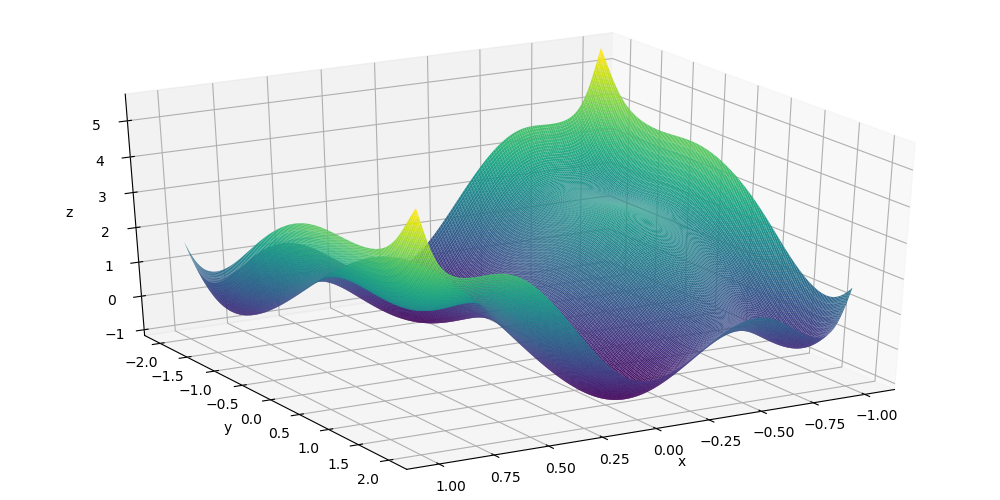

In [13]:
plot(nn)

In [0]:
#
# Grid Search (takes ~2 hours) -------> (50, 5, 0.0001, 'CG') error on val of ~0.00022
#

"""
param_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    print("current combination :", comb)
    print("\n")
    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))
"""

------------------------------------

# Exercise 2.1

the error reduces to: $\underset{w_0, b_0, v}{min} \frac{1}{2P} (\sum_{p=1}^P v_j \sum_{i=1}^nw_{ij}x + b_j)- y^p)^2 + \rho||\mathbf{\omega}||^2 = ||\mathbf{v}(\mathbf{W}\mathbf{X} + \mathbf{b}) - \mathbf{Y}||^2 + \rho||\mathbf{v}||^2$



In [9]:
X_train, X_test, y_train, y_test = data_split(data, val = False)

In [11]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.uniform(-1,1,(self.N, self.X.shape[0]))
        self.b = np.random.uniform(-0.5,0.5,(self.N,1))
        self.v = np.random.uniform(-0.5,0.5,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) 
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

In [12]:
class Mlp_El(ShallowNeuralNetwork):

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))
    
    def optimize(self):
        
        z = self.w @ self.X - self.b
        H = self.g(z)
        H = np.concatenate((H.T, np.sqrt(self.rho)*np.identity(self.N))).T
        y = np.concatenate((self.y, np.zeros(self.N)))

        self.v =  np.linalg.inv(H @ H.T) @ H @ y # equal to self.v = y @ np.linalg.pinv(H) (moore-penrose pseudo inverse)
        
            
    # forward propagation
    def predict(self, x, w, b, v):
        
        a = w @ x - b
        z = self.g(a)
        self.output = v @ z
        return self.output

In [12]:
# extreme  learning traning
print("begin training...", "\n")
start = time.time()

while nn.mse(X_test, y_test, nn.w, nn.b, nn.v) > 0.020 or nn.mse(X_train, y_train, nn.w, nn.b, nn.v) > 0.02:
    nn = Mlp_El(X_train, y_train, N = 50, sigma = 5, rho = 10e-5)
    nn.optimize()
    
time_elapsed = time.time() - start
print("finished training.")
        
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

begin training... 

finished training.
Train Error : 0.0005103933267482669
Test Error : 0.0010464845664015746


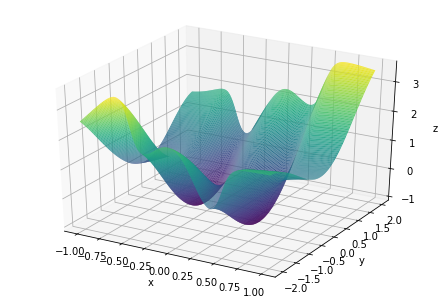

In [13]:
plot(nn)

# Two Block Decomposition MLP

In [194]:
class two_blocks(Mlp):
    def grad_v(self, params):

        w, b, v = self.w,self.b,params
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        self.dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        return self.dv.reshape(-1)

    
    def grad_w_b(self, params):
        
        w, b = self.separate_w_b(params)
        v = self.v
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        self.dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        self.db = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        self.db =(1/self.X.shape[1]) *  np.sum(self.db, axis = 1, keepdims = True)
        self.d_w_b = np.concatenate([array.reshape(-1) for array in [self.dw, self.db]])
        return self.d_w_b
    
    def separate_w_b(self, l):
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        w, b = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return w, b
    
    def inits(self):
        return np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])

    
    def loss_v(self, v):
        return 0.5 * np.mean(np.square((self.predict(self.X, self.w, self.b, v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [self.w, self.b, v]])))
    
    
    def loss_w_b(self,wb):
        w,b = self.separate_w_b(wb)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, self.v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [w, b, self.v]])))
    
    
    def optimizer_1(self):
        bound_1 = 1e-5 # 1e-9
        bound_2 = 1e-4 # 1e-6
        theta = .5 #.75
        i = 0
        wb = np.concatenate([array.reshape(-1) for array in [self.w, self.b]])
        b1_condition = True
        b2_condition = True
        while  i < 50 :
            #Block 1
            print("begin iteration ",i)
            if b1_condition <= 2:
                
                print("begin block 1")
                min_v = minimize(self.loss_v,x0 = self.v,method = 'BFGS',jac = self.grad_v,options={"gtol":1e-1*bound_1}).x
                if (np.linalg.norm(self.grad_v(min_v)) > bound_1) or \
                (self.mse(self.X_test,self.y_test,self.w,self.b,min_v.reshape(1,self.N)) >= self.mse(self.X_test,self.y_test,self.w,self.b,self.v)):
                    self.v = min_v.reshape(1,self.N)
                    b1_condition += 1
                    print("gradient v:",np.linalg.norm(self.grad_v(self.v)))
                    print("opt_v is Terminated...||grad_v|| > epsilon_1")
                    
                else:
                    b1_condition = 0
                    self.v = min_v.reshape(1,self.N)
                    bound_1 *= theta
                    print("opt_v ...done")
                    print("gradient v:",np.linalg.norm(self.grad_v(self.v)))
                    print("Error after opt_v: \n",\
                          "training_error: ", self.mse(self.X,self.y,self.w,self.b,self.v),\
                         "\n Test_Error: ", self.mse(self.X_test,self.y_test,self.w,self.b,self.v))
            else:
                print("Block 2 is optimal")
            #Block 2
            print("begin block 2")
            if b2_condition <= 2:
                min_w_b = minimize(self.loss_w_b,x0 = wb, method = self.method,jac = self.grad_w_b,options={"gtol":1e-1*bound_2,"maxiter":5000}).x
                nw,nb = self.separate_w_b(min_w_b)
                if np.linalg.norm(self.grad_w_b(min_w_b)) > bound_2 or\
                self.mse(self.X_test,self.y_test,nw,nb,self.v) >= self.mse(self.X_test,self.y_test,self.w,self.b,self.v):
                    self.w,self.b = self.separate_w_b(min_w_b)
                    b2_condition += 1
                    wb = np.concatenate([array.reshape(-1) for array in [self.w, self.b]])
                    print("opt_w_b is Terminated...||grad_w_b|| > epsilon_2")
                    print("gradient wb:",np.linalg.norm(self.grad_w_b(wb)))
                   
                    
                else:
                    b2_condition = 0
                    self.w,self.b = self.separate_w_b(min_w_b)
                    bound_2 = bound_2 * theta
                    wb = np.concatenate([array.reshape(-1) for array in [self.w, self.b]])
                    print("opt_w_b ...done")
                    print("\n training error after opt_w_b: ",\
                          "training_error", self.mse(self.X,self.y,self.w,self.b,self.v),\
                         "Test_Error: ", self.mse(self.X_test,self.y_test,self.w,self.b,self.v))
                    print("gradient wb:",np.linalg.norm(self.grad_w_b(wb)))
            else:
                print("Block 2 is optimal")
            if b1_condition > 2 and b2_condition > 2:
                break
            i += 1
            print("round ",i," finished with: \n",\
                     "training_error: ", self.mse(self.X,self.y,self.w,self.b,self.v), "\n test_error: ",\
                      self.mse(self.X_test,self.y_test,self.w,self.b,self.v))
        

In [195]:
testing_nn = two_blocks(X_train, y_train,X_test, y_test,X_val,y_val, N = 128, sigma = 6.5, rho = 1e-5, method = "BFGS")

In [196]:
testing_nn.optimizer_1()

begin iteration  0
begin block 1
opt_v ...done
gradient v: 4.336517303866239e-06
Error after opt_v: 
 training_error:  0.005526490826213883 
 Test_Error:  0.039972764474760676
begin block 2
opt_w_b is Terminated...||grad_w_b|| > epsilon_2
gradient wb: 0.0004073186226553671
round  1  finished with: 
 training_error:  6.804178934434235e-06 
 test_error:  3.851180943571666e-05
begin iteration  1
begin block 1
gradient v: 1.4512114190634396e-06
opt_v is Terminated...||grad_v|| > epsilon_1
begin block 2
opt_w_b ...done

 training error after opt_w_b:  training_error 7.516055680227044e-06 Test_Error:  3.959481586367287e-05
gradient wb: 2.2700659365027655e-05
round  2  finished with: 
 training_error:  7.516055680227044e-06 
 test_error:  3.959481586367287e-05
begin iteration  2
begin block 1
gradient v: 1.1159042918306015e-06
opt_v is Terminated...||grad_v|| > epsilon_1
begin block 2
opt_w_b ...done

 training error after opt_w_b:  training_error 7.859578702572793e-06 Test_Error:  3.94186707

In [166]:
testing_nn.mse(testing_nn.X_test,testing_nn.y_test,testing_nn.w,testing_nn.b,testing_nn.v)

2.9102940062896165e-05

<IPython.core.display.Javascript object>


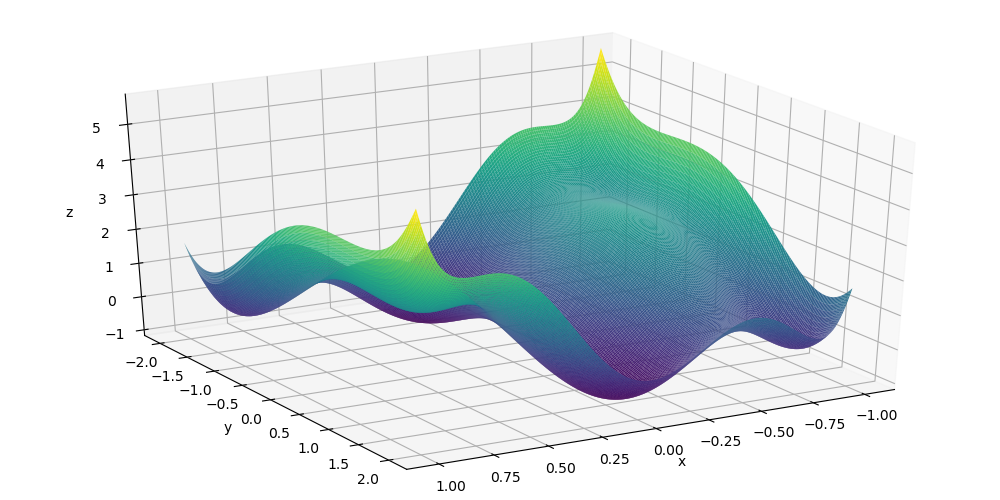

In [72]:
plot(testing_nn)

In [86]:
testing_nn.mse(testing_nn.X_test,testing_nn.y_test,testing_nn.w,testing_nn.b,testing_nn.v)

2.2066058251698348e-05